In [29]:
import pandas as pd
import numpy as np
import seaborn as snb
import matplotlib.pyplot as py 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
german_credit_dataset = pd.read_excel("german_credit_data.xlsx")
german_credit_dataset.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [5]:
german_credit_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [6]:
german_credit_dataset.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [7]:
german_credit_dataset.corr()

,Age,Job,Credit amount,Duration
Age,1.000000,0.015673,0.032716,-0.036136
Job,0.015673,1.000000,0.285385,0.210910
Credit amount,0.032716,0.285385,1.000000,0.624984
Duration,-0.036136,0.210910,0.624984,1.000000


In [8]:
def unique_value(data_set, column_name):
    return data_set[column_name].nunique()

print("Number of the Unique Values:")
print(unique_value(german_credit_dataset,list(german_credit_dataset.columns)))

Number of the Unique Values:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64


In [9]:
# Identify missing values
missing_values = german_credit_dataset.isnull().sum().sort_values(ascending=False)

missing_values_df = pd.DataFrame({
    'Missing Values': missing_values.values,
    'Percentage Missing': (missing_values / len(german_credit_dataset)) * 100
})

# Print the DataFrame
print("\n", missing_values_df)



                   Missing Values  Percentage Missing
Checking account             394                39.4
Saving accounts              183                18.3
Age                            0                 0.0
Sex                            0                 0.0
Job                            0                 0.0
Housing                        0                 0.0
Credit amount                  0                 0.0
Duration                       0                 0.0
Purpose                        0                 0.0
Risk                           0                 0.0


In [10]:
#Filling missing values with mode
german_credit_dataset["Saving accounts"].fillna(german_credit_dataset['Saving accounts'].mode()[0], inplace=True)
german_credit_dataset["Checking account"].fillna(german_credit_dataset['Checking account'].mode()[0], inplace=True)

In [11]:
# Separate columns into numerical and categorical
numerical_columns = german_credit_dataset.select_dtypes(include=['number']).columns
categorical_columns = german_credit_dataset.select_dtypes(include=['object']).columns

# Display the results
print("Numerical Columns:\n", numerical_columns)
print("\nCategorical Columns:\n", categorical_columns)

Numerical Columns:
 Index(['Age', 'Job', 'Credit amount', 'Duration'], dtype='object')

Categorical Columns:
 Index(['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose',
       'Risk'],
      dtype='object')


In [12]:
german_credit_dataset.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,little,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,little,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [13]:
data = {'Category': ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose',
       'Risk']}

In [14]:
# cat_cols = [col for col in german_credit_dataset.columns if german_credit_dataset[col].dtypes == 'O']


# def one_hot_encoder(dataframe, categorical_cols, nan_as_category=True):
#     original_columns = list(dataframe.columns)
#     dataframe = pd.get_dummies(dataframe, columns=categorical_cols, dummy_na=nan_as_category, drop_first=True)
#     new_columns = [c for c in dataframe.columns if c not in original_columns]
#     return dataframe, new_columns

# german_credit_dataset, new_cols_ohe = one_hot_encoder(german_credit_dataset, cat_cols)
# german_credit_dataset.head(5)

In [15]:
print(german_credit_dataset.columns)


Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')


In [16]:
# import pandas as pd
# from sklearn.preprocessing import OneHotEncoder

# data = {'Category': ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']}
# german_credit_dataset = pd.DataFrame(data)

# # Initialize the OneHotEncoder
# encoder = OneHotEncoder(sparse=False, drop='first')

# # Fit and transform the categorical feature
# one_hot_encoded = encoder.fit_transform(german_credit_dataset[['Category']])

# # Get feature names after one-hot encoding
# feature_names = encoder.get_feature_names_out(['Category'])

# # Create a DataFrame with the one-hot encoded features
# one_hot_df = pd.DataFrame(one_hot_encoded, columns=feature_names)

# # Concatenate the one-hot encoded DataFrame with the original DataFrame
# df = pd.concat([german_credit_dataset, one_hot_df], axis=1)

# # Drop the original categorical column
# df = df.drop(['Category'], axis=1)

# df.head(100)


In [24]:
# List of categorical columns to one-hot encode
categorical_columns = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']

# Perform one-hot encoding for specified categorical columns
data_encoded = pd.get_dummies(german_credit_dataset, columns=categorical_columns)

data_encoded.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Age,67,22,49,45,53,35,53,35,61,28,25,24,22,60,28
Job,2,2,1,2,2,1,2,3,1,3,2,2,2,1,2
Credit amount,1169,5951,2096,7882,4870,9055,2835,6948,3059,5234,1295,4308,1567,1199,1403
Duration,6,48,12,42,24,36,24,36,12,30,12,48,12,24,15
Sex_female,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1
Sex_male,1,0,1,1,1,1,1,1,1,1,0,0,0,1,0
Housing_free,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0
Housing_own,1,1,1,0,0,0,1,0,1,1,0,0,1,1,0
Housing_rent,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1
Saving accounts_little,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1


In [20]:
data_encoded.columns

Index(['Age', 'Job', 'Credit amount', 'Duration', 'Sex_female', 'Sex_male',
       'Housing_free', 'Housing_own', 'Housing_rent', 'Saving accounts_little',
       'Saving accounts_moderate', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Checking account_little',
       'Checking account_moderate', 'Checking account_rich',
       'Purpose_business', 'Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others', 'Risk_bad', 'Risk_good'],
      dtype='object')

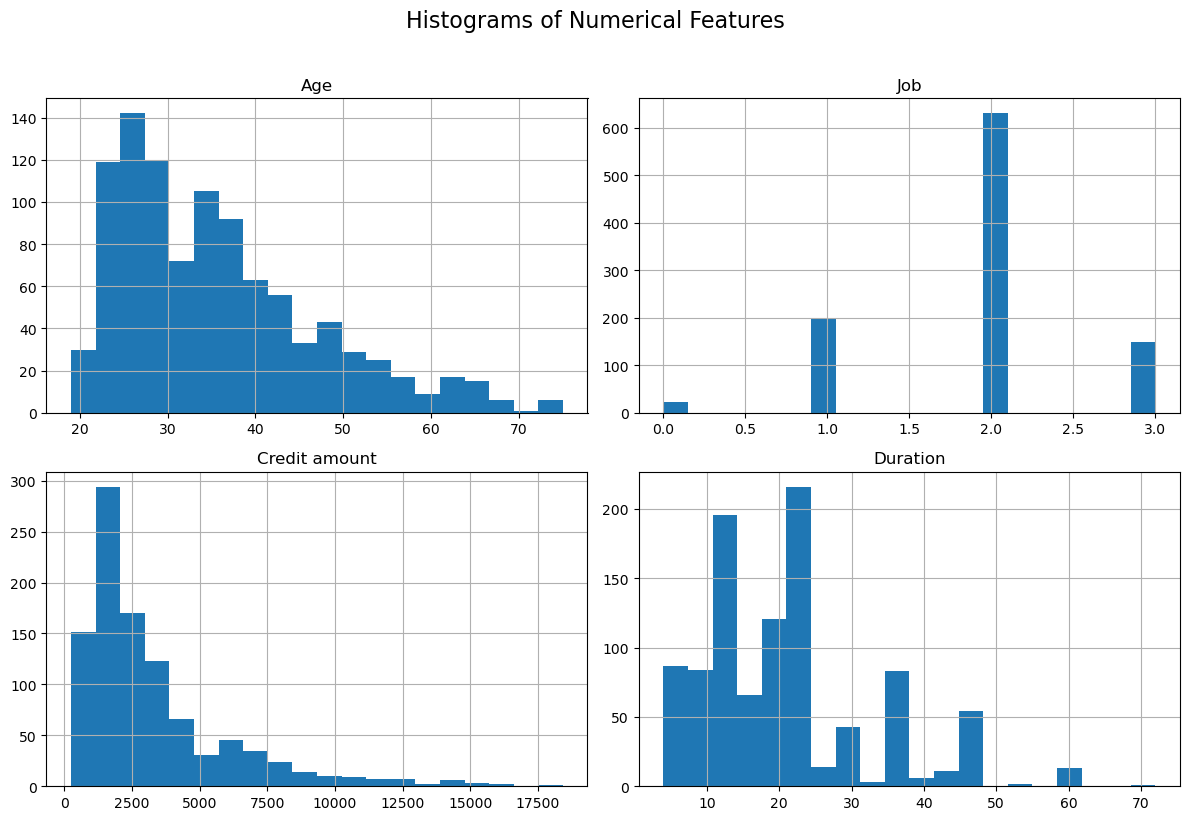

In [26]:
# Plot histograms for numerical features
german_credit_dataset[numerical_columns].hist(bins=20, figsize=(12,8))
py.suptitle("Histograms of Numerical Features", y=1.02, size=16)
py.tight_layout()
py.show()

In [27]:
from scipy.stats import skew

skewness = german_credit_dataset[numerical_columns].apply(lambda x: skew(x))

# Display skewness values
print("Skewness of Numerical Features:\n", skewness)

# Identify features with skewness greater than a threshold (e.g., 0.5)
skewed_features = skewness[abs(skewness) > 0.5].index


Skewness of Numerical Features:
 Age              1.019208
Job             -0.373733
Credit amount    1.946702
Duration         1.092542
dtype: float64


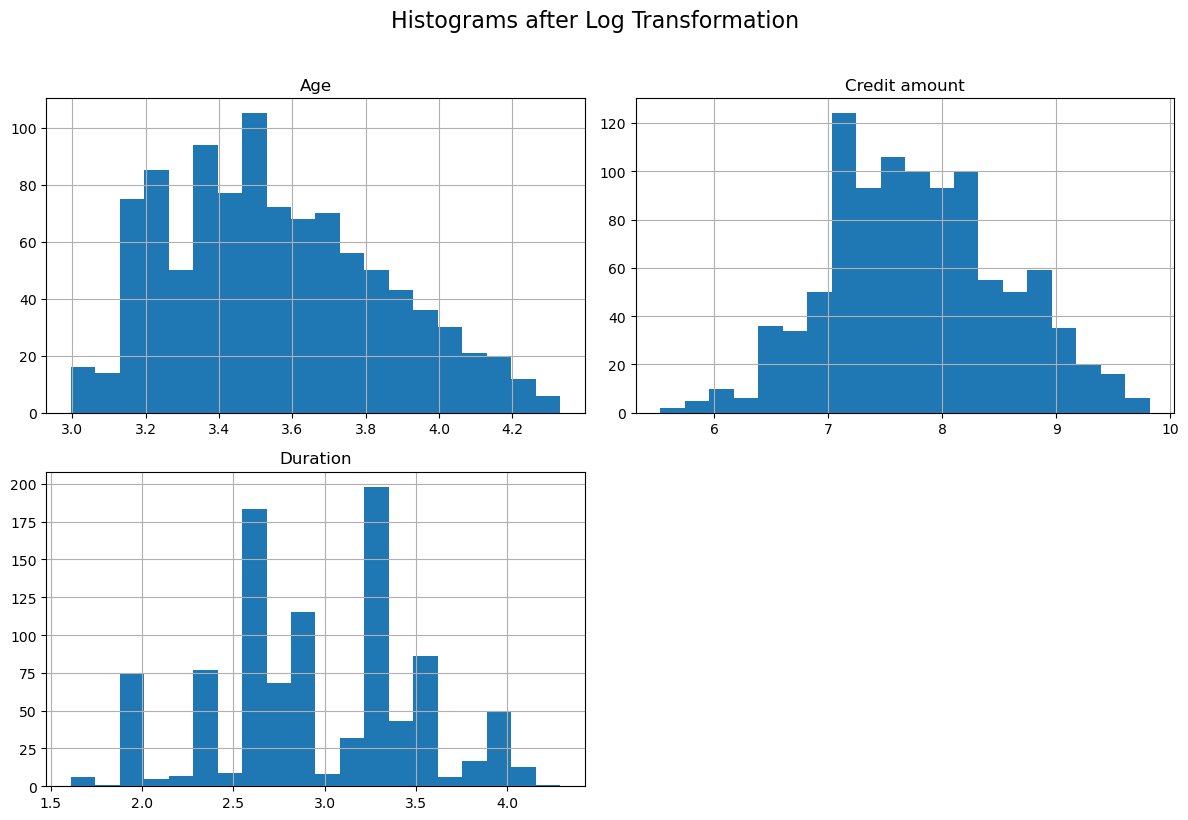

In [30]:
# Apply log transformation to skewed features
german_credit_dataset[skewed_features] = np.log1p(german_credit_dataset[skewed_features])

# Display histograms after log transformation
german_credit_dataset[skewed_features].hist(bins=20, figsize=(12,8))
py.suptitle("Histograms after Log Transformation", y=1.02, size=16)
py.tight_layout()
py.show()